In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import seaborn as sns



start = "2015-01-01"
end = "2025-01-01"


In [6]:
index = yf.download("^GSPC", start="2015-01-01", end="2025-01-01")
vix = yf.download("^VIX", start="2015-01-01", end="2025-01-01")
skew = yf.download("^SKEW", start=start, end=end)



spx = index.add_prefix("SPX_")
vix   = vix.add_prefix("VIX_")
skew  = skew.add_prefix("SKEW_")






C:\Users\maxim\AppData\Local\Temp\ipykernel_13180\1176649704.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  index = yf.download("^GSPC", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\maxim\AppData\Local\Temp\ipykernel_13180\1176649704.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\maxim\AppData\Local\Temp\ipykernel_13180\1176649704.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  skew = yf.download("^SKEW", start=start, end=end)
[*********************100%***********************]  1 of 1 completed


In [7]:
df = spx.join(vix, how="inner").join(skew, how="inner")

df = df.loc[:, ~df.columns.duplicated()].copy()

df.head()
if isinstance(df.columns, pd.MultiIndex):  # Check if columns are MultiIndex? si je met pas ca, j'ai des problemes de double indexation
    df.columns = [col[0] for col in df.columns] 
df

,SPX_Close,SPX_High,SPX_Low,SPX_Open,SPX_Volume,VIX_Close,VIX_High,VIX_Low,VIX_Open,VIX_Volume,SKEW_Close,SKEW_High,SKEW_Low,SKEW_Open,SKEW_Volume
Date,,,,,,,,,,,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,17.790001,20.139999,17.049999,17.760000,0,128.660004,128.660004,128.660004,128.660004,0
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,19.920000,21.290001,19.190001,19.190001,0,127.790001,127.790001,127.790001,127.790001,0
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,21.120001,22.900000,19.520000,20.330000,0,125.269997,125.269997,125.269997,125.269997,0
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,19.309999,20.719999,19.040001,20.150000,0,123.559998,123.559998,123.559998,123.559998,0
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,17.010000,18.090000,16.990000,17.930000,0,124.769997,124.769997,124.769997,124.769997,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000,14.270000,17.040001,14.270000,16.969999,0,180.089996,180.089996,180.089996,180.089996,0
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000,14.730000,15.930000,14.550000,14.990000,0,173.720001,173.720001,173.720001,173.720001,0
2024-12-27,5970.839844,6006.169922,5932.950195,6006.169922,3159610000,15.950000,18.450001,15.290000,15.380000,0,167.919998,167.919998,167.919998,167.919998,0


In [8]:
# on calcule nos features derives des indices  

df['SPX_Return'] = np.log(df['SPX_Close'] / df['SPX_Close'].shift(1)) # return log du s&p500  

df['RealizedVol_21d'] = df['SPX_Return'].rolling(window=21).std()*np.sqrt(252) # vol sur 1 mois  annualisé

df['IV_RV_Spread'] = (df['VIX_Close'] / 100) - df['RealizedVol_21d'] # spread entre vol implicite du vix et vol realisee  

df['VIX_Change'] = df['VIX_Close'].pct_change() # variation du vix  

df['SKEW_Change'] = df['SKEW_Close'].diff() # variation du skew  

df['Abs_Return'] = df['SPX_Return'].abs() # amplitude des mouvements du spx  

df['Vol_Ratio'] = (df['VIX_Close'] / 100) / df['RealizedVol_21d'] # ratio entre vol implicite et vol réalisée  


df = df.dropna()  # on vire les lignes avec des NaN prcq on fait un rolling donc la 1ere ligne saute  


df = df[['SPX_Close','SPX_Open','SPX_Volume', 'VIX_Close','VIX_Open', 'SKEW_Close','SKEW_Open',
         'SPX_Return', 'Abs_Return', 'RealizedVol_21d',
         'IV_RV_Spread', 'VIX_Change', 'SKEW_Change', 'Vol_Ratio']]


df


,SPX_Close,SPX_Open,SPX_Volume,VIX_Close,VIX_Open,SKEW_Close,SKEW_Open,SPX_Return,Abs_Return,RealizedVol_21d,IV_RV_Spread,VIX_Change,SKEW_Change,Vol_Ratio
Date,,,,,,,,,,,,,,
2015-02-03,2050.030029,2022.709961,4615900000,17.330000,18.410000,129.779999,129.779999,0.014336,0.014336,0.180978,-0.007678,-0.108080,-0.199997,0.957575
2015-02-04,2041.510010,2048.860107,4141920000,18.330000,17.820000,126.199997,126.199997,-0.004165,0.004165,0.169203,0.014097,0.057703,-3.580002,1.083315
2015-02-05,2062.520020,2043.449951,3821990000,16.850000,17.290001,127.540001,127.540001,0.010239,0.010239,0.168782,-0.000282,-0.080742,1.340004,0.998329
2015-02-06,2055.469971,2062.280029,4232970000,17.290001,16.290001,125.620003,125.620003,-0.003424,0.003424,0.165366,0.007534,0.026113,-1.919998,1.045561
2015-02-09,2046.739990,2053.469971,3549540000,18.549999,19.160000,129.850006,129.850006,-0.004256,0.004256,0.153966,0.031534,0.072874,4.230003,1.204813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,6040.040039,5984.629883,1757720000,14.270000,16.969999,180.089996,180.089996,0.010982,0.010982,0.137112,0.005588,-0.149583,9.440002,1.040756
2024-12-26,6037.589844,6024.970215,2904530000,14.730000,14.990000,173.720001,173.720001,-0.000406,0.000406,0.136852,0.010448,0.032235,-6.369995,1.076345
2024-12-27,5970.839844,6006.169922,3159610000,15.950000,15.380000,167.919998,167.919998,-0.011117,0.011117,0.140977,0.018523,0.082824,-5.800003,1.131394


In [9]:
df.to_csv(r"C:\Documents\ESILV\A4\Machine Learning\Projet\dataset.csv", sep=';', decimal='.', index=True)



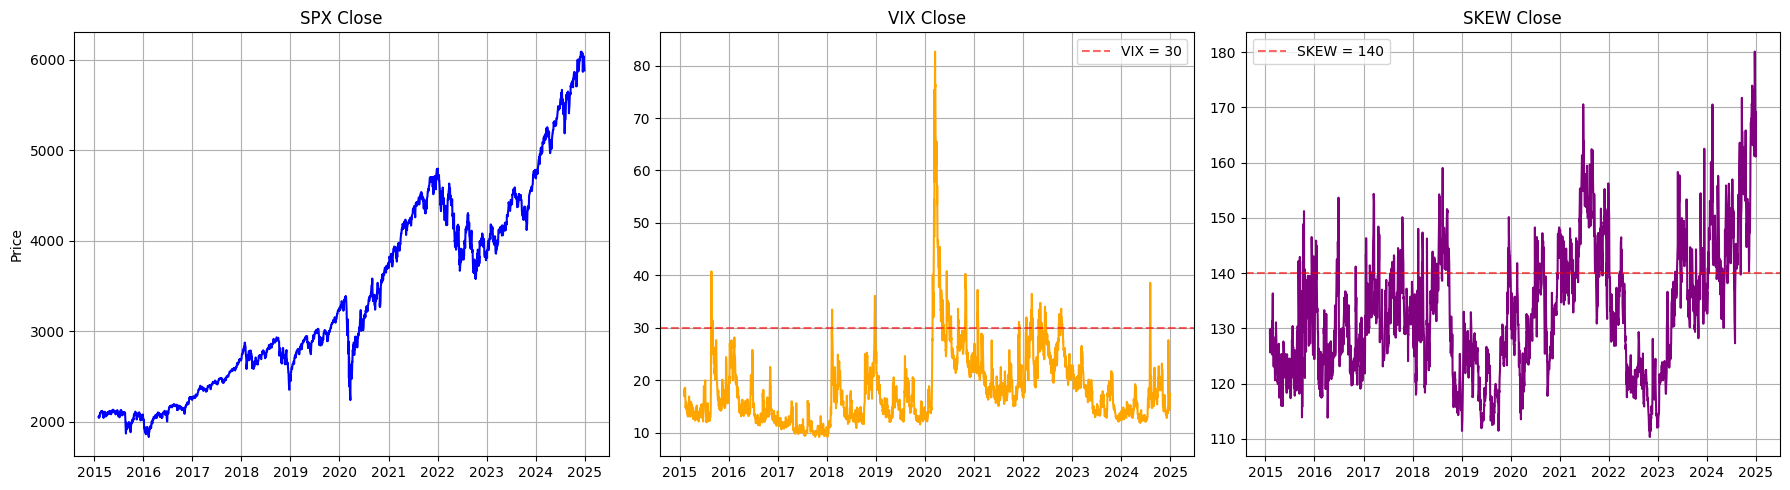

In [ ]:

# Créer les subplots : 3 graphiques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# SPX
axes[0].plot(df.index, df['SPX_Close'], color='blue')
axes[0].set_title('SPX Close')
axes[0].set_ylabel('Price')
axes[0].grid(True)

# VIX
axes[1].plot(df.index, df['VIX_Close'], color='orange')
axes[1].axhline(30, color='red', linestyle='--', alpha=0.6, label='VIX = 30')
axes[1].set_title('VIX Close')
axes[1].legend()
axes[1].grid(True)

# SKEW
axes[2].plot(df.index, df['SKEW_Close'], color='purple')
axes[2].axhline(140, color='red', linestyle='--', alpha=0.6, label='SKEW = 140')
axes[2].set_title('SKEW Close')
axes[2].legend()
axes[2].grid(True)

# Mise en page
plt.tight_layout()
plt.show()

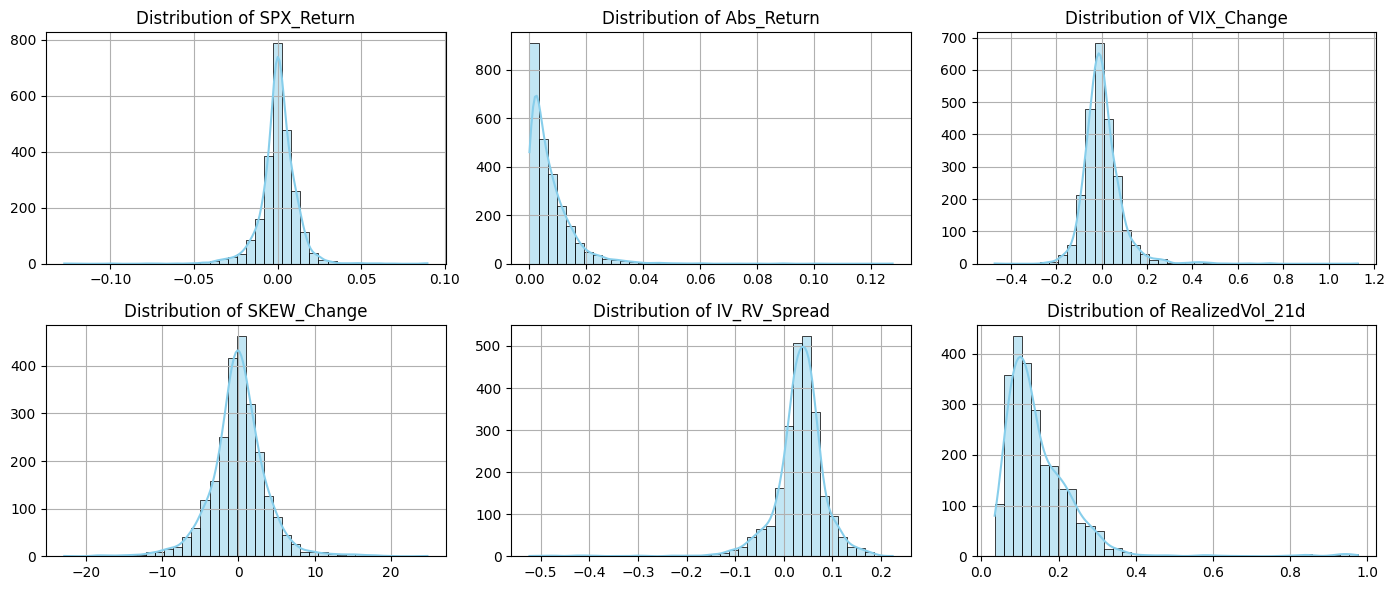

In [12]:
# Liste des variables à tracer
features = ['SPX_Return', 'Abs_Return', 'VIX_Change', 'SKEW_Change', 'IV_RV_Spread', 'RealizedVol_21d']

# Créer les subplots : 2 lignes × 3 colonnes
fig, axes = plt.subplots(2, 3, figsize=(14, 6))
axes = axes.flatten()

# Tracer chaque histogramme + KDE
for i, feature in enumerate(features):
    sns.histplot(df[feature], kde=True, bins=40, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].grid(True)

# Ajustement de l'espacement
plt.tight_layout()
plt.show()


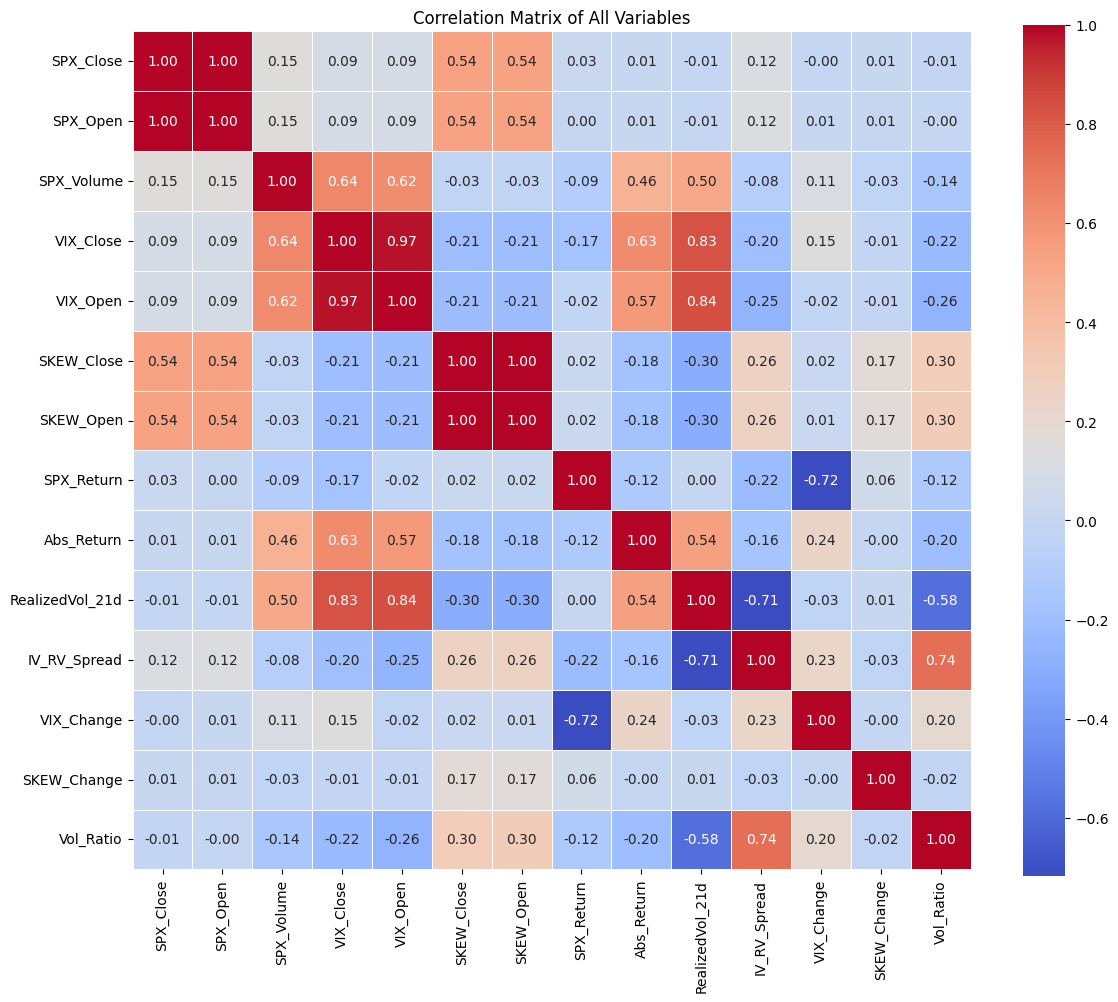

In [14]:
correlation_matrix = df.corr(numeric_only=True)

# Affichage de la heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix of All Variables")
plt.tight_layout()
plt.show()
